In [62]:
import glob
import os
import json
import re
import sys

import numpy as np
import pandas as pd
import pickle

from collections import defaultdict
from bs4 import BeautifulSoup
os.environ['KERAS_BACKEND']='theano'
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
%matplotlib inline

In [63]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

No. of unique classes:  30


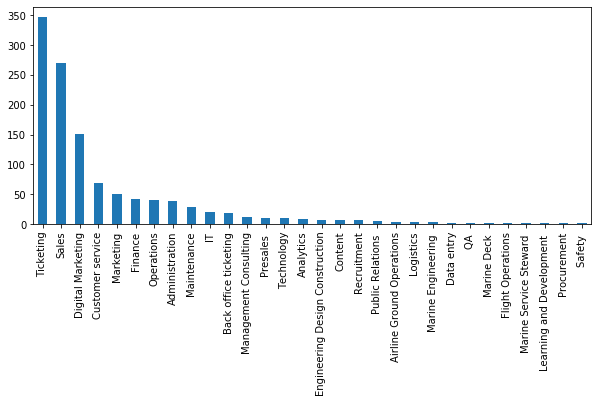

In [64]:
dep_df = pd.read_csv('data/document_departments.csv')

departments = sorted(dep_df.Department.unique())
print('No. of unique classes: ', len(departments))

plt.figure(figsize=(10,4))
dep_df['Department'].value_counts().plot(kind='bar');

dep_and_id = {value: key for key, value in enumerate(departments)}
def dep_to_id(dep):
    return dep_and_id[dep]

In [65]:
list1 = []

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

for i in glob.glob('data/docs/*.json'):
    file = json.load(open(i))
    desc = file['jd_information']['description']
    desc = REPLACE_BY_SPACE_RE.sub(' ', desc)
#     desc = BAD_SYMBOLS_RE.sub(' ', desc)
#     desc = desc.split()
                    
    list1.append([int(file['_id']), desc, file['jd_information']['description']])
    
desc_df = pd.DataFrame(list1, columns=['Document ID', 'Description', 'Raw Description'])

In [66]:
df = pd.merge(dep_df, desc_df, left_on='Document ID', right_on='Document ID')
df['Department'] = df['Department'].apply(dep_to_id)
df.head()

,Document ID,Department,Description,Raw Description
0,8196431,5,Designation- TeleMarketing ExecutiveKeyskills-...,Designation- TeleMarketing ExecutiveKeyskills-...
1,8278123,7,We need committed &amp result-oriented people...,We need committed &amp; result-oriented people...
2,8331625,27,Greetings from Akkam Immigrations!!!Immediate ...,Greetings from Akkam Immigrations!!!Immediate ...
3,8331003,3,Dear Candidates Greetings From Continental Imm...,"Dear Candidates,Greetings From Continental Imm..."
4,8277939,7,We need committed &amp result-oriented people...,We need committed &amp; result-oriented people...


In [67]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df.Description)
sequences = tokenizer.texts_to_sequences(df.Description)

word_index = tokenizer.word_index

print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 6295


In [68]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(df.Department))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Shape of Data Tensor: (1162, 1000)
Shape of Label Tensor: (1162, 30)


In [69]:
embeddings_index = {}
f = open('glove6b100dtxt/glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [70]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [71]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [72]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
preds = Dense(len(departments), activation='softmax')(l_lstm)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Bidirectional LSTM")
model.summary()

Bidirectional LSTM
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1000, 100)         629600    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_3 (Dense)              (None, 30)                6030      
Total params: 796,430
Trainable params: 796,430
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp=ModelCheckpoint('model_rnn.hdf5', monitor='val_acc', verbose=1, save_best_only=True)
history=model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=2, callbacks=[cp])

Train on 930 samples, validate on 232 samples
Epoch 1/10
930/930 [==============================] - 540s 580ms/step - loss: 1.9838 - acc: 0.4237 - val_loss: 1.8593 - val_acc: 0.4828

Epoch 00001: val_acc improved from -inf to 0.48276, saving model to model_rnn.hdf5
Epoch 2/10
930/930 [==============================] - 546s 587ms/step - loss: 1.8105 - acc: 0.4376 - val_loss: 1.8103 - val_acc: 0.4655

Epoch 00002: val_acc did not improve from 0.48276
Epoch 3/10
930/930 [==============================] - 548s 589ms/step - loss: 1.6704 - acc: 0.5000 - val_loss: 1.7496 - val_acc: 0.5000

Epoch 00003: val_acc improved from 0.48276 to 0.50000, saving model to model_rnn.hdf5
Epoch 4/10
930/930 [==============================] - 545s 586ms/step - loss: 1.4990 - acc: 0.5366 - val_loss: 1.7843 - val_acc: 0.4612

Epoch 00004: val_acc did not improve from 0.50000
Epoch 5/10
930/930 [==============================] - 547s 588ms/step - loss: 1.4026 - acc: 0.5763 - val_loss: 1.8151 - val_acc: 0.4914

